### Randomizing an adjacency

Algorithms to randomize an adjacency matrix of a binary undirected network preserving each node degree.

In [1]:
%matplotlib inline
import ctypes
import numpy             as np
import matplotlib.pyplot as plt
from   tqdm              import tqdm

In [2]:
_ra = ctypes.CDLL('./libradj.so')

In [3]:
_ra.randomize_adjacency.argtypes = (ctypes.c_int, ctypes.c_int, ctypes.c_int, 
                                    ctypes.POINTER(ctypes.POINTER(ctypes.c_int)), 
                                    ctypes.POINTER(ctypes.c_int), ctypes.POINTER(ctypes.c_int), ctypes.c_int)
_ra.randomize_adjacency.restype  = ctypes.POINTER(ctypes.POINTER(ctypes.c_int))

### Defining wrapper for C function in python

In [4]:
def randomize_adjacency(A, n_rewires, seed):
    global _ra
    A_copy = np.array(A, dtype=np.int32).copy()
    # Number of nodes
    n_nodes = A_copy.shape[0]
    # Getting edges
    i,j   = np.tril_indices_from(A_copy, k=-1)
    w     = A_copy[i,j]
    edges = np.array([j,i]).T
    i,j   = edges[w.astype(bool),:].T
    # Number of edges
    n_edges = len(i)
    
    #
    UI8Ptr = ctypes.POINTER(ctypes.c_int)
    UI8PtrPtr = ctypes.POINTER(UI8Ptr)

    ct_arr = np.ctypeslib.as_ctypes(A_copy)
    UI8PtrArr = UI8Ptr * ct_arr._length_
    ct_ptr = ctypes.cast(UI8PtrArr(*(ctypes.cast(row, UI8Ptr) for row in ct_arr)), UI8PtrPtr)

    
    array_type  = (ctypes.c_int * n_edges)
    
    # Call function
    Arn = _ra.randomize_adjacency(ctypes.c_int(n_rewires), ctypes.c_int(n_nodes), ctypes.c_int(n_edges), \
                                  ct_ptr, array_type(*i), array_type(*j), ctypes.c_int(seed))
    
    Arn_py = np.array([[Arn[i][j] for j in range(n_nodes)] for i in range(n_nodes)], dtype=Arn._type_._type_._type_)
    return Arn_py

### Python implementation

In [5]:
def randomize_adjacency_py(A, n_rewires,seed):
    np.random.seed(seed)
    A_copy  = A.copy()
    # Number of nodes
    n_nodes = A_copy.shape[0]
    # Getting edges
    i,j   = np.tril_indices_from(A_copy, k=-1)
    w     = A_copy[i,j]
    edges = np.array([j,i]).T
    i,j   = edges[w.astype(bool),:].T
    # Number of edges
    n_edges = len(i)
    # Iterating over n_rewires
    n = 0
    while(n<n_rewires):
        e1, e2 = np.random.choice(range(n_edges), size=2, replace = False)
        a = i[e1]
        b = j[e1]
        c = i[e2]
        d = j[e2]
        if (A_copy[a,d]==0 and A_copy[c,b]==0 and a!=d and a!=c and c!=b and b!=d):
            j[e1] = d
            i[e2] = b
            j[e2] = c
            
            A_copy[a,b] = 0
            A_copy[b,a] = 0
            A_copy[c,d] = 0
            A_copy[d,c] = 0
            A_copy[a,d] = 1
            A_copy[d,a] = 1
            A_copy[c,b] = 1
            A_copy[b,c] = 1
            n+=1
        else:
            continue
    return A_copy

#### Load an adjacency matrix

In [6]:
A = np.loadtxt('adj.txt',delimiter=' ', dtype=int)

#### C

In [16]:
Arn = randomize_adjacency(A, int(111 * np.log(1/1e-7)), 0)

#### Python

In [17]:
Arn_py = randomize_adjacency_py(A, int(111 * np.log(1/1e-7)), 0)

([], <a list of 0 Text major ticklabel objects>)

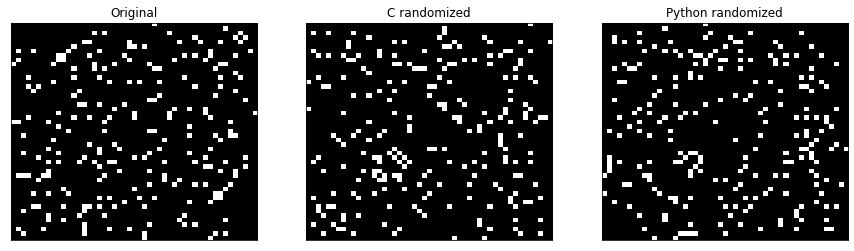

In [18]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(A,aspect='auto',cmap='gray', origin = 'lower')
plt.title('Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.imshow(Arn,aspect='auto',cmap='gray', origin = 'lower')
plt.title('C randomized')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(Arn_py,aspect='auto',cmap='gray', origin = 'lower')
plt.title('Python randomized')
plt.xticks([])
plt.yticks([])

#### Check if the degrees were preserved

In [19]:
d_o = A.sum(axis = 1)
d_c = Arn.sum(axis = 1)
d_p = Arn_py.sum(axis = 1)

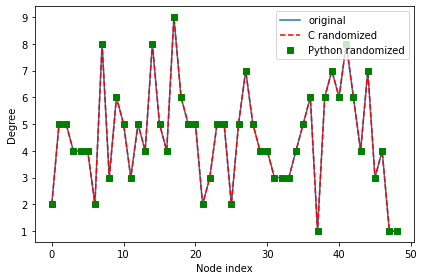

In [23]:
plt.plot(d_o, label = 'original')
plt.plot(d_c, 'r--', label = 'C randomized')
plt.plot(d_p, 'gs', label = 'Python randomized')
plt.xlabel('Node index')
plt.ylabel('Degree')
plt.legend()
plt.tight_layout()

### Comparing perfomance between Python, C and igraph

In [74]:
import igraph   as ig
import networkx as nx

In [75]:
def instantiate_igraph(A):
    #n_nodes = A.shape[0]
    # Getting edges
    #i,j   = np.tril_indices_from(A, k=-1)
    #w     = A[i,j]
    #edges = np.array([j,i]).T
    #i,j   = edges[w.astype(bool),:].T
    g = nx.Graph(A)
    return ig.Graph(A.shape[0],g.edges)  #ig.Graph(n_nodes, zip(i,j))

In [107]:
n_rewires = np.arange(10, 111 * np.log(1/1e-8), 100, dtype=int)
ex_t      = np.zeros([3,2,len(n_rewires)])
g         = instantiate_igraph(A)

In [108]:
for i in range(n_rewires.shape[0]):
    t1 = %timeit -o randomize_adjacency(A, n_rewires[i], 0)
    ex_t[0,0,i]=t1.average
    ex_t[0,1,i]=t1.stdev
    t2 = %timeit -o randomize_adjacency_py(A, n_rewires[i], 0)
    ex_t[1,0,i]=t2.average
    ex_t[1,1,i]=t2.stdev
    t3 = %timeit -o g.rewire(n_rewires[i])
    ex_t[2,0,i]=t3.average
    ex_t[2,1,i]=t3.stdev

776 µs ± 29.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
605 µs ± 2.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
23.1 µs ± 543 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
793 µs ± 42.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.34 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
68 µs ± 5.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
895 µs ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
12 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
129 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.18 ms ± 54.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
20.1 ms ± 462 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
212 µs ± 36.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.18 ms ± 40.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
26.1 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loop

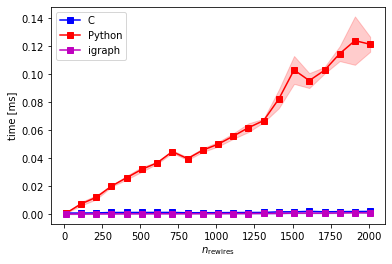

In [122]:
plt.plot(n_rewires, ex_t[0,0], 's-b', label = 'C')
plt.fill_between(n_rewires, ex_t[0,0]-ex_t[0,1], ex_t[0,0]+ex_t[0,1], color='b', alpha = .2)
#
plt.plot(n_rewires, ex_t[1,0], 'r-s', label = 'Python')
plt.fill_between(n_rewires, ex_t[1,0]-ex_t[1,1], ex_t[1,0]+ex_t[1,1], color='r', alpha = .2)
#
plt.plot(n_rewires, ex_t[2,0], 's-m', label = 'igraph')
plt.fill_between(n_rewires, ex_t[2,0]-ex_t[2,1], ex_t[2,0]+ex_t[2,1], color='b', alpha = .2)
plt.xlabel(r'$n_{\rm rewires}$')
plt.ylabel('time [ms]')
plt.legend()

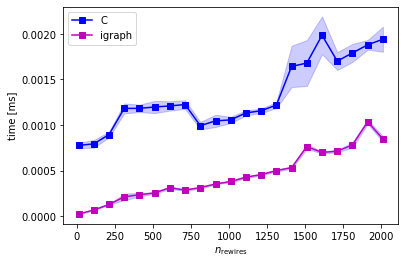

In [123]:
plt.plot(n_rewires, ex_t[0,0], 's-b', label = 'C')
plt.fill_between(n_rewires, ex_t[0,0]-ex_t[0,1], ex_t[0,0]+ex_t[0,1], color='b', alpha = .2)
#
plt.plot(n_rewires, ex_t[2,0], 's-m', label = 'igraph')
plt.fill_between(n_rewires, ex_t[2,0]-ex_t[2,1], ex_t[2,0]+ex_t[2,1], color='b', alpha = .2)
plt.legend()
plt.xlabel(r'$n_{\rm rewires}$')
plt.ylabel('time [ms]')
plt.legend()